In [1]:
import pandas as pd 
import numpy as np
import datetime as dt 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler

## Import data

In [4]:
df=pd.read_excel("C:\\Users\\Admin\\Downloads\\De bai\\PizzaHut.xlsx", sheet_name="Purchasing data")
df

,Unnamed: 0,BillID,Channel,OrderFrom,TransactionDate,SalesAmount,CustomerID,CustomerGender,VoucherStatus,Province
0,0,0,Take Away,CALL CENTER,2021-10-01 00:00:00+00:00,296891,1753863,Unknown,No,Ho Chi Minh City
1,1,1,Take Away,STORE,2021-10-01 00:00:00+00:00,301782,1124050,Unknown,No,Hanoi
2,2,2,Take Away,WEBSITE,2021-10-01 00:00:00+00:00,319792,1626827,Male,No,Hanoi
3,3,3,Take Away,STORE,2021-10-01 00:00:00+00:00,424762,125643,Male,No,Hanoi
4,4,4,Delivery,STORE,2021-10-01 00:00:00+00:00,280031,2117237,Unknown,No,Hanoi
...,...,...,...,...,...,...,...,...,...,...
1048570,1048570,1048570,Delivery,STORE,2023-01-09 00:00:00+00:00,178107,1398136,Unknown,No,Southern Provinces
1048571,1048571,1048571,Take Away,STORE,2023-01-09 00:00:00+00:00,331447,2023258,Unknown,No,Hanoi
1048572,1048572,1048572,Take Away,WEBSITE,2023-01-09 00:00:00+00:00,381509,2041510,Female,Yes,Southern Provinces
1048573,1048573,1048573,Take Away,STORE,2023-01-09 00:00:00+00:00,508205,1927215,Unknown,Yes,Hanoi


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Unnamed: 0       1048575 non-null  int64 
 1   BillID           1048575 non-null  int64 
 2   Channel          1048575 non-null  object
 3   OrderFrom        1048575 non-null  object
 4   TransactionDate  1048575 non-null  object
 5   SalesAmount      1048575 non-null  int64 
 6   CustomerID       1048575 non-null  int64 
 7   CustomerGender   1048575 non-null  object
 8   VoucherStatus    1048575 non-null  object
 9   Province         1048575 non-null  object
dtypes: int64(4), object(6)
memory usage: 80.0+ MB


In [6]:
null=df.isnull()
for i in null.columns.values.tolist():
    print(i)
    print(null[i].value_counts())
    print("----------------------------------")

Unnamed: 0
Unnamed: 0
False    1048575
Name: count, dtype: int64
----------------------------------
BillID
BillID
False    1048575
Name: count, dtype: int64
----------------------------------
Channel
Channel
False    1048575
Name: count, dtype: int64
----------------------------------
OrderFrom
OrderFrom
False    1048575
Name: count, dtype: int64
----------------------------------
TransactionDate
TransactionDate
False    1048575
Name: count, dtype: int64
----------------------------------
SalesAmount
SalesAmount
False    1048575
Name: count, dtype: int64
----------------------------------
CustomerID
CustomerID
False    1048575
Name: count, dtype: int64
----------------------------------
CustomerGender
CustomerGender
False    1048575
Name: count, dtype: int64
----------------------------------
VoucherStatus
VoucherStatus
False    1048575
Name: count, dtype: int64
----------------------------------
Province
Province
False    1048575
Name: count, dtype: int64
-----------------------------

In [7]:
df.dtypes.value_counts()

object    6
int64     4
Name: count, dtype: int64

In [8]:
df.describe()

,Unnamed: 0,BillID,SalesAmount,CustomerID
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.242870e+05,5.242870e+05,3.048722e+05,1.087017e+06
std,3.026977e+05,3.026977e+05,3.108000e+05,6.270554e+05
min,0.000000e+00,0.000000e+00,6.569000e+03,0.000000e+00
25%,2.621435e+05,2.621435e+05,1.789620e+05,5.452245e+05
50%,5.242870e+05,5.242870e+05,2.589940e+05,1.088264e+06
75%,7.864305e+05,7.864305e+05,3.579980e+05,1.628730e+06
max,1.048574e+06,1.048574e+06,5.773168e+07,2.174083e+06


## RFM model

### Caculate Recency, Frequency, Monetary

In [9]:
df1 = df.loc[:, ['CustomerID', 'SalesAmount', 'TransactionDate']]
# Lấy ngày giao dịch cuối cùng của từng khách hàng
df1['Last Order'] = df.groupby('CustomerID')['TransactionDate'].transform('max')
# Chuyển đổi định dạng ngày
df1['TransactionDate'] = pd.to_datetime(df['TransactionDate']).dt.tz_localize(None)
df1['Last Order'] = pd.to_datetime(df1['Last Order']).dt.tz_localize(None)
# Tạo ngày phân tích cố định
df1['Report Date'] = '2023-1-10'
df1['Report Date'] = pd.to_datetime(df1['Report Date'])
# Tính recency (khoảng thời gian từ lần mua cuối đến ngày báo cáo)
df1['Recency'] = (df1['Report Date'] - df1['Last Order']).dt.days
# Tính frequency (số lần giao dịch của từng khách hàng)
df1['Frequency'] = df.groupby('CustomerID')['TransactionDate'].transform('count')
# Tính tổng GMV cho từng khách hàng
df1['Monetary'] = df.groupby('CustomerID')['SalesAmount'].transform('sum')

In [10]:
df_new = df1.loc[:, ['CustomerID', 'Recency', 'Frequency', 'Monetary']]
df_new.drop_duplicates(inplace=True)
df_new.reset_index()
df_new

,CustomerID,Recency,Frequency,Monetary
0,1753863,338,3,1506161
1,1124050,349,3,1183064
2,1626827,117,5,993004
3,125643,32,52,9923370
4,2117237,79,16,4058641
...,...,...,...,...
1048565,513009,1,1,305686
1048567,320877,1,1,87696
1048568,479318,1,1,270973
1048569,2138358,1,1,221992


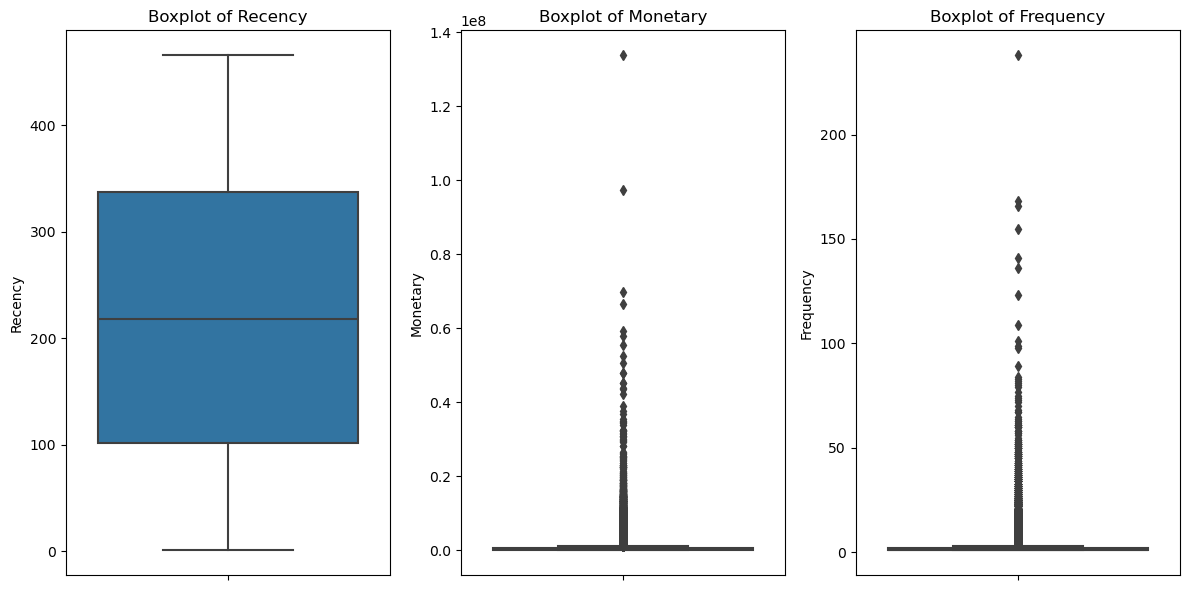

In [11]:
# Vẽ boxplot cho RFM
plt.figure(figsize=(12, 6))
# Boxplot Recency
plt.subplot(1, 3, 1)
sns.boxplot(y=df_new['Recency'])
plt.title('Boxplot of Recency')
plt.ylabel('Recency')
# Boxplot Monetary
plt.subplot(1, 3, 2)
sns.boxplot(y=df_new['Monetary'])
plt.title('Boxplot of Monetary')
plt.ylabel('Monetary')
# Boxplot Frequency
plt.subplot(1, 3, 3) 
sns.boxplot(y=df_new['Frequency'])
plt.title('Boxplot of Frequency')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

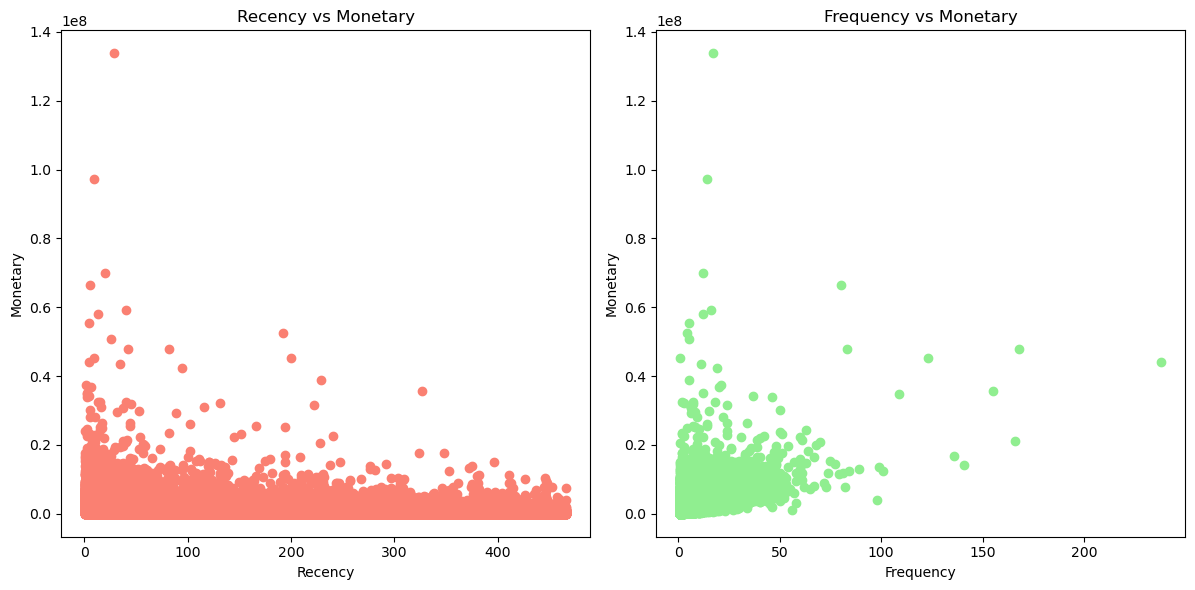

In [12]:
# Thiết lập kích thước toàn bộ figure
plt.figure(figsize=(18, 6))
# Scatter plot: Recency vs Monetary
plt.subplot(1, 3, 1)
plt.scatter(df_new['Recency'], df_new['Monetary'], color='salmon')
plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
# Scatter plot: Frequency vs Monetary
plt.subplot(1, 3, 2)
plt.scatter(df_new['Frequency'], df_new['Monetary'], color='lightgreen')
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.tight_layout()
plt.show()

### RFM scores

In [13]:
# Tính điểm Recency
max_recency = df_new['Recency'].max()
min_recency = df_new['Recency'].min()
condlist_r = [
    (df_new['Recency'] >= min_recency) & (df_new['Recency'] <= 0.2 * max_recency),
    (df_new['Recency'] > 0.2 * max_recency) & (df_new['Recency'] <= 0.4 * max_recency),
    (df_new['Recency'] > 0.4 * max_recency) & (df_new['Recency'] <= 0.6 * max_recency),
    (df_new['Recency'] > 0.6 * max_recency) & (df_new['Recency'] <= 0.8 * max_recency),
    (df_new['Recency'] > 0.8 * max_recency) & (df_new['Recency'] <= max_recency)
]
choicelist_r = [5, 4, 3, 2, 1]  # Recency thấp hơn thì điểm cao hơn
df_new['R'] = np.select(condlist_r, choicelist_r)

# Tính điểm Frequency
max_frequency = df_new['Frequency'].max()
min_frequency = df_new['Frequency'].min()
condlist_f = [
    (df_new['Frequency'] >= min_frequency) & (df_new['Frequency'] <= 0.2 * max_frequency),
    (df_new['Frequency'] > 0.2 * max_frequency) & (df_new['Frequency'] <= 0.4 * max_frequency),
    (df_new['Frequency'] > 0.4 * max_frequency) & (df_new['Frequency'] <= 0.6 * max_frequency),
    (df_new['Frequency'] > 0.6 * max_frequency) & (df_new['Frequency'] <= 0.8 * max_frequency),
    (df_new['Frequency'] > 0.8 * max_frequency) & (df_new['Frequency'] <= max_frequency)
]
choicelist_f = [1, 2, 3, 4, 5]  # Frequency cao hơn thì điểm cao hơn
df_new['F'] = np.select(condlist_f, choicelist_f)

# Tính điểm Monetary
max_monetary = df_new['Monetary'].max()
min_monetary = df_new['Monetary'].min()
condlist_m = [
    (df_new['Monetary'] >= min_monetary) & (df_new['Monetary'] <= 0.2 * max_monetary),
    (df_new['Monetary'] > 0.2 * max_monetary) & (df_new['Monetary'] <= 0.4 * max_monetary),
    (df_new['Monetary'] > 0.4 * max_monetary) & (df_new['Monetary'] <= 0.6 * max_monetary),
    (df_new['Monetary'] > 0.6 * max_monetary) & (df_new['Monetary'] <= 0.8 * max_monetary),
    (df_new['Monetary'] > 0.8 * max_monetary) & (df_new['Monetary'] <= max_monetary)
]
choicelist_m = [1, 2, 3, 4, 5]  # Monetary cao hơn thì điểm cao hơn
df_new['M'] = np.select(condlist_m, choicelist_m)


In [14]:
df_new['RFM'] = df_new['R'].astype('str') + df_new['F'].astype('str') + df_new['M'].astype('str')
df_new['RFM'] = pd.to_numeric(df_new['RFM'])
df_new

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM
0,1753863,338,3,1506161,2,1,1,211
1,1124050,349,3,1183064,2,1,1,211
2,1626827,117,5,993004,4,1,1,411
3,125643,32,52,9923370,5,2,1,521
4,2117237,79,16,4058641,5,1,1,511
...,...,...,...,...,...,...,...,...
1048565,513009,1,1,305686,5,1,1,511
1048567,320877,1,1,87696,5,1,1,511
1048568,479318,1,1,270973,5,1,1,511
1048569,2138358,1,1,221992,5,1,1,511


### Segment

In [15]:
#Load segment data
seg = pd.read_csv("C:\\Users\\Admin\\Downloads\\segment scores.csv")
seg.rename(columns={'scores': 'RFM'}, inplace=True)
seg

,segment,RFM
0,About To Sleep,213
1,About To Sleep,221
2,About To Sleep,231
3,About To Sleep,241
4,About To Sleep,251
...,...,...
123,Promising,521
124,Promising,522
125,Promising,523
126,Promising,524


In [16]:
df_final = df_new.merge(seg, on='RFM', how='left')
df_final

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,segment
0,1753863,338,3,1506161,2,1,1,211,Hibernating customers
1,1124050,349,3,1183064,2,1,1,211,Hibernating customers
2,1626827,117,5,993004,4,1,1,411,New Customers
3,125643,32,52,9923370,5,2,1,521,Promising
4,2117237,79,16,4058641,5,1,1,511,New Customers
...,...,...,...,...,...,...,...,...,...
583637,513009,1,1,305686,5,1,1,511,New Customers
583638,320877,1,1,87696,5,1,1,511,New Customers
583639,479318,1,1,270973,5,1,1,511,New Customers
583640,2138358,1,1,221992,5,1,1,511,New Customers


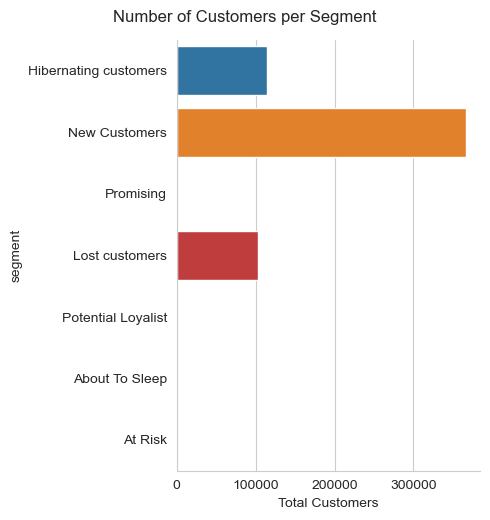

In [19]:
#Draw bar chart to show number of customers per segment
sns.set_style("whitegrid")
g = sns.catplot(y="segment", data=df_final, orient='h', kind="count")
g.fig.suptitle("Number of Customers per Segment", y=1.03)
g.set(xlabel="Total Customers")
plt.show()

## VoucherStatus

In [20]:
df2 = df
df2['Month'] = pd.to_datetime(df2['TransactionDate']).dt.month
df2

,Unnamed: 0,BillID,Channel,OrderFrom,TransactionDate,SalesAmount,CustomerID,CustomerGender,VoucherStatus,Province,Month
0,0,0,Take Away,CALL CENTER,2021-10-01 00:00:00+00:00,296891,1753863,Unknown,No,Ho Chi Minh City,10
1,1,1,Take Away,STORE,2021-10-01 00:00:00+00:00,301782,1124050,Unknown,No,Hanoi,10
2,2,2,Take Away,WEBSITE,2021-10-01 00:00:00+00:00,319792,1626827,Male,No,Hanoi,10
3,3,3,Take Away,STORE,2021-10-01 00:00:00+00:00,424762,125643,Male,No,Hanoi,10
4,4,4,Delivery,STORE,2021-10-01 00:00:00+00:00,280031,2117237,Unknown,No,Hanoi,10
...,...,...,...,...,...,...,...,...,...,...,...
1048570,1048570,1048570,Delivery,STORE,2023-01-09 00:00:00+00:00,178107,1398136,Unknown,No,Southern Provinces,1
1048571,1048571,1048571,Take Away,STORE,2023-01-09 00:00:00+00:00,331447,2023258,Unknown,No,Hanoi,1
1048572,1048572,1048572,Take Away,WEBSITE,2023-01-09 00:00:00+00:00,381509,2041510,Female,Yes,Southern Provinces,1
1048573,1048573,1048573,Take Away,STORE,2023-01-09 00:00:00+00:00,508205,1927215,Unknown,Yes,Hanoi,1


### VIF

In [21]:
# Tương quan giữa SalesAmount và Month
print("SalesAmount vs Month:")
print("Giả thuyết H₀: Giá trị đơn hàng và tháng không liên quan tuyến tính.")
print("Giả thuyết H₁: Giá trị đơn hàng và tháng có liên quan tuyến tính.")
numerical_vars = ['SalesAmount', 'Month']
corr_matrix = df2[numerical_vars].corr()
print("Ma trận tương quan:\n", corr_matrix)
if abs(corr_matrix.loc['SalesAmount', 'Month']) > 0.7:
    print("Kết luận: Có dấu hiệu liên quan mạnh - Cần xem xét đa cộng tuyến.")
else:
    print("Kết luận: Không có liên quan mạnh - Không có đa cộng tuyến.")

SalesAmount vs Month:
Giả thuyết H₀: Giá trị đơn hàng và tháng không liên quan tuyến tính.
Giả thuyết H₁: Giá trị đơn hàng và tháng có liên quan tuyến tính.
Ma trận tương quan:
              SalesAmount     Month
SalesAmount     1.000000  0.012721
Month           0.012721  1.000000
Kết luận: Không có liên quan mạnh - Không có đa cộng tuyến.


In [22]:
# Chi-square giữa các biến phân loại
categorical_vars = ['Channel', 'OrderFrom', 'CustomerGender', 'Province']
for i in range(len(categorical_vars)):
    for j in range(i+1, len(categorical_vars)):
        print(f"\n{categorical_vars[i]} vs {categorical_vars[j]}:")
        print(f"Giả thuyết H₀: {categorical_vars[i]} và {categorical_vars[j]} không liên quan.")
        print(f"Giả thuyết H₁: {categorical_vars[i]} và {categorical_vars[j]} có liên quan.")
        crosstab = pd.crosstab(df2[categorical_vars[i]], df2[categorical_vars[j]])
        chi2, p, _, _ = chi2_contingency(crosstab)
        print(f"Giá trị p-value: {p}")
        if p < 0.05:
            print("Kết luận: Bác bỏ H₀ - Hai biến có liên quan, có thể gây đa cộng tuyến.")
        else:
            print("Kết luận: Không bác bỏ H₀ - Hai biến không liên quan chặt chẽ.")


Channel vs OrderFrom:
Giả thuyết H₀: Channel và OrderFrom không liên quan.
Giả thuyết H₁: Channel và OrderFrom có liên quan.
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Hai biến có liên quan, có thể gây đa cộng tuyến.

Channel vs CustomerGender:
Giả thuyết H₀: Channel và CustomerGender không liên quan.
Giả thuyết H₁: Channel và CustomerGender có liên quan.
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Hai biến có liên quan, có thể gây đa cộng tuyến.

Channel vs Province:
Giả thuyết H₀: Channel và Province không liên quan.
Giả thuyết H₁: Channel và Province có liên quan.
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Hai biến có liên quan, có thể gây đa cộng tuyến.

OrderFrom vs CustomerGender:
Giả thuyết H₀: OrderFrom và CustomerGender không liên quan.
Giả thuyết H₁: OrderFrom và CustomerGender có liên quan.
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Hai biến có liên quan, có thể gây đa cộng tuyến.

OrderFrom vs Province:
Giả thuyết H₀: OrderFrom và Province không liên quan.
Giả thuyết H₁: Or

In [25]:
# Tính VIF
print("\nKiểm tra VIF (đo mức độ trùng lặp thông tin):")
print("Giả thuyết H₀: Các biến không có đa cộng tuyến (VIF < 10).")
print("Giả thuyết H₁: Các biến có đa cộng tuyến (VIF >= 10).")
features = ['Channel', 'OrderFrom', 'CustomerGender', 'Province', 'SalesAmount', 'Month']
X = pd.get_dummies(df2[features], drop_first= True)
X = X.astype(float)  # Chuyển tất cả thành float để tránh lỗi kiểu dữ liệu
# Tính VIF
vif_df2 = pd.DataFrame()
vif_df2['Feature'] = X.columns
vif_df2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(f"\nGiá trị VIF:\n{vif_df2}")
if (vif_df2['VIF'] >= 10).any():
    print("Kết luận: Bác bỏ H₀ - Có biến bị đa cộng tuyến, cần xem xét loại bỏ.")
else:
    print("Kết luận: Không bác bỏ H₀ - Không có đa cộng tuyến nghiêm trọng.")


Kiểm tra VIF (đo mức độ trùng lặp thông tin):
Giả thuyết H₀: Các biến không có đa cộng tuyến (VIF < 10).
Giả thuyết H₁: Các biến có đa cộng tuyến (VIF >= 10).

Giá trị VIF:
                        Feature       VIF
0                   SalesAmount  1.906133
1                         Month  3.961674
2               Channel_Dine In  1.179851
3             Channel_Take Away  2.704520
4         OrderFrom_CALL CENTER  2.163940
5               OrderFrom_STORE  5.857426
6             OrderFrom_WEBSITE  2.348223
7           CustomerGender_Male  2.156476
8        CustomerGender_Unknown  5.171526
9     Province_Ho Chi Minh City  1.860077
10   Province_Nothern Provinces  1.512355
11  Province_Southern Provinces  1.724173
Kết luận: Không bác bỏ H₀ - Không có đa cộng tuyến nghiêm trọng.


### Bivariate Analysis

Bivariate Analysis meaning two variable analysis
Column can be of two types - 1. Continuous and 2. Categorical
So Bivariate Analysis can be of THREE TYPES
- Continuous vs Continuous - Correlation Coefficient and VIF
 - Categorical vs Categorical - Chi Square Test
 - Categorical vs Continuous - T Test(N < 30), Z Test(N > 30) & ANOVA

BillID và CustomerID không phân tích vì là biến định danh.

In [26]:
# Channel vs VoucherStatus
print("\nChannel vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào kênh đặt hàng.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo kênh đặt hàng.")
channel_cross = pd.crosstab(df2['Channel'], df2['VoucherStatus'], normalize='index')
print(channel_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['Channel'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Kênh đặt hàng có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Kênh đặt hàng không ảnh hưởng rõ rệt.")


Channel vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào kênh đặt hàng.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo kênh đặt hàng.
VoucherStatus        No       Yes
Channel                          
Delivery       0.885586  0.114414
Dine In        0.951546  0.048454
Take Away      0.928127  0.071873
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Kênh đặt hàng có ảnh hưởng.


In [27]:
# OrderFrom vs VoucherStatus
print("\nOrderFrom vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào nguồn đặt hàng.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo nguồn đặt hàng.")
orderfrom_cross = pd.crosstab(df2['OrderFrom'], df2['VoucherStatus'], normalize='index')
print(orderfrom_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['OrderFrom'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Nguồn đặt hàng có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Nguồn đặt hàng không ảnh hưởng rõ rệt.")


OrderFrom vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào nguồn đặt hàng.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo nguồn đặt hàng.
VoucherStatus        No       Yes
OrderFrom                        
APP            0.567624  0.432376
CALL CENTER    0.996375  0.003625
STORE          0.984264  0.015736
WEBSITE        0.820767  0.179233
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Nguồn đặt hàng có ảnh hưởng.


In [28]:
# Month vs VoucherStatus
print("\nMonth vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không thay đổi theo tháng.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo tháng.")
month_cross = pd.crosstab(df2['Month'], df2['VoucherStatus'], normalize='index')
print(month_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['Month'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Tháng có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Tháng không ảnh hưởng rõ rệt.")


Month vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không thay đổi theo tháng.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo tháng.
VoucherStatus        No       Yes
Month                            
1              0.917595  0.082405
2              0.961156  0.038844
3              0.958579  0.041421
4              0.947702  0.052298
5              0.937146  0.062854
6              0.948140  0.051860
7              0.896907  0.103093
8              0.790031  0.209969
9              0.829139  0.170861
10             0.906456  0.093544
11             0.903621  0.096379
12             0.897613  0.102387
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Tháng có ảnh hưởng.


In [29]:
# SalesAmount vs VoucherStatus
print("\nSalesAmount vs VoucherStatus:")
print("Giả thuyết H₀: Giá trị đơn hàng trung bình không khác nhau giữa đơn có và không dùng voucher.")
print("Giả thuyết H₁: Giá trị đơn hàng trung bình khác nhau giữa hai nhóm.")
yes_sales = df2[df2['VoucherStatus'] == 'Yes']['SalesAmount']
no_sales = df2[df2['VoucherStatus'] == 'No']['SalesAmount']
t_stat, p_val = ttest_ind(yes_sales, no_sales)
print(f"Giá trị p-value: {p_val}")
if p_val < 0.05:
    print("Kết luận: Bác bỏ H₀ - Giá trị đơn hàng có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Giá trị đơn hàng không ảnh hưởng rõ rệt.")


SalesAmount vs VoucherStatus:
Giả thuyết H₀: Giá trị đơn hàng trung bình không khác nhau giữa đơn có và không dùng voucher.
Giả thuyết H₁: Giá trị đơn hàng trung bình khác nhau giữa hai nhóm.
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Giá trị đơn hàng có ảnh hưởng.


In [30]:
# CustomerGender vs VoucherStatus
print("\nCustomerGender vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào giới tính.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo giới tính.")
gender_cross = pd.crosstab(df2['CustomerGender'], df2['VoucherStatus'], normalize='index')
print(gender_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['CustomerGender'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Giới tính có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Giới tính không ảnh hưởng rõ rệt.")


CustomerGender vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào giới tính.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo giới tính.
VoucherStatus         No       Yes
CustomerGender                    
Female          0.819054  0.180946
Male            0.798674  0.201326
Unknown         0.975446  0.024554
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Giới tính có ảnh hưởng.


In [31]:
# Province vs VoucherStatus
print("\nProvince vs VoucherStatus:")
print("Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào tỉnh.")
print("Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo tỉnh.")
province_cross = pd.crosstab(df2['Province'], df2['VoucherStatus'], normalize='index')
print(province_cross)
chi2, p, _, _ = chi2_contingency(pd.crosstab(df2['Province'], df2['VoucherStatus']))
print(f"Giá trị p-value: {p}")
if p < 0.05:
    print("Kết luận: Bác bỏ H₀ - Tỉnh có ảnh hưởng.")
else:
    print("Kết luận: Không bác bỏ H₀ - Tỉnh không ảnh hưởng rõ rệt.")


Province vs VoucherStatus:
Giả thuyết H₀: Việc dùng voucher không phụ thuộc vào tỉnh.
Giả thuyết H₁: Việc dùng voucher thay đổi tùy theo tỉnh.
VoucherStatus             No       Yes
Province                              
Hanoi               0.901225  0.098775
Ho Chi Minh City    0.878348  0.121652
Nothern Provinces   0.944138  0.055862
Southern Provinces  0.929810  0.070190
Giá trị p-value: 0.0
Kết luận: Bác bỏ H₀ - Tỉnh có ảnh hưởng.


Hầu hết các biến đều ảnh hưởng đến VoucherStatus, kết hợp với kết quả từ VIF thì có đa cộng tuyến nhưng không đến mức nghiêm trọng. Kết quả là giữ nguyên các biến.

### Train Model

In [32]:
# Chuẩn bị dữ liệu
features = ['Channel', 'OrderFrom', 'CustomerGender', 'Province', 'SalesAmount', 'Month']
X = pd.get_dummies(df2[features], drop_first=True)
y = df2['VoucherStatus'].map({'No': 0, 'Yes': 1})
# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Undersampling
rus = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
# Kiểm tra phân bố sau undersampling
print("\nPhân bố tập train sau Undersampling:")
print(pd.Series(y_train_balanced).value_counts())


Phân bố tập train sau Undersampling:
VoucherStatus
0    76898
1    76898
Name: count, dtype: int64


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


#### Random Forest

In [35]:
# Random Forest
model_rf = RandomForestClassifier(random_state=42, n_estimators=200)
model_rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]
# Lưu kết quả
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, target_names=['No', 'Yes'], output_dict=True)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_prob_rf)
rf_auc = auc(rf_fpr, rf_tpr)
print("Random Forest training completed.")

Random Forest training completed.


#### XGBoost

In [36]:
# XGBoost
model_xgb = XGBClassifier(random_state=42, eval_metric='logloss')
model_xgb.fit(X_train_balanced, y_train_balanced)
y_pred_xgb = model_xgb.predict(X_test)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]
# Lưu kết quả
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=['No', 'Yes'], output_dict=True)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_prob_xgb)
xgb_auc = auc(xgb_fpr, xgb_tpr)
print("XGBoost training completed.")

XGBoost training completed.


#### LightGBM

In [37]:
# LightGBM
model_lgb = LGBMClassifier(random_state=42)
model_lgb.fit(X_train_balanced, y_train_balanced)
y_pred_lgb = model_lgb.predict(X_test)
y_prob_lgb = model_lgb.predict_proba(X_test)[:, 1]
# Lưu kết quả
lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
lgb_report = classification_report(y_test, y_pred_lgb, target_names=['No', 'Yes'], output_dict=True)
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, y_prob_lgb)
lgb_auc = auc(lgb_fpr, lgb_tpr)
print("LightGBM training completed.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 76898, number of negative: 76898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 153796, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM training completed.


#### Results


Mô hình: Random Forest | Accuracy: 0.8027
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
No         0.9755     0.8030     0.8809     190490    
Yes        0.2907     0.8001     0.4265     19225     
Macro Avg  0.6331     0.8015     0.6537     209715    
--------------------------------------------------

Mô hình: XGBoost | Accuracy: 0.8257
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
No         0.9870     0.8188     0.8951     190490    
Yes        0.3323     0.8935     0.4845     19225     
Macro Avg  0.6597     0.8562     0.6898     209715    
--------------------------------------------------

Mô hình: LightGBM | Accuracy: 0.8267
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
No         0.9871     0.8199     0.8958     190490    
Yes        0.3338     0.8940     0.4861     19225     
Macro Avg  0.6604     

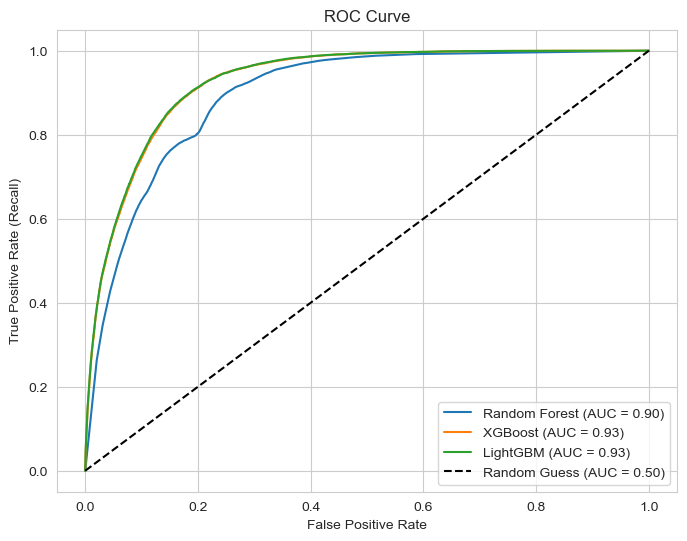

In [39]:
models = {
    'Random Forest': {'accuracy': rf_accuracy, 'report': rf_report, 'fpr': rf_fpr, 'tpr': rf_tpr, 'auc': rf_auc},
    'XGBoost': {'accuracy': xgb_accuracy, 'report': xgb_report, 'fpr': xgb_fpr, 'tpr': xgb_tpr, 'auc': xgb_auc},
    'LightGBM': {'accuracy': lgb_accuracy, 'report': lgb_report, 'fpr': lgb_fpr, 'tpr': lgb_tpr, 'auc': lgb_auc}
}

# Hiển thị báo cáo hiệu suất
for name, result in models.items():
    print(f"\nMô hình: {name} | Accuracy: {result['accuracy']:.4f}")
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 50)
    for cls in ['No', 'Yes']:
        print(f"{cls:<10} {result['report'][cls]['precision']:<10.4f} {result['report'][cls]['recall']:<10.4f} {result['report'][cls]['f1-score']:<10.4f} {result['report'][cls]['support']:<10.0f}")
    print(f"{'Macro Avg':<10} {result['report']['macro avg']['precision']:<10.4f} {result['report']['macro avg']['recall']:<10.4f} {result['report']['macro avg']['f1-score']:<10.4f} {result['report']['macro avg']['support']:<10.0f}")
    print("-" * 50)

# Vẽ ROC Curve 
plt.figure(figsize=(8, 6))
for name, result in models.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()